In [2]:
pip install librosa

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   -------------------------------

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import scipy.signal as signal

def load_sounds(dataset_path):
    metadata=pd.read_csv(os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv'))
    metadata=metadata[metadata['fold']== 1]
    return metadata

In [3]:
def apply_windows(audio_data, sr):
    """Apply different window functions to audio data and compute spectrograms."""
    def hann_window(M):
        n = np.arange(M)
        return 0.5 * (1 - np.cos(2 * np.pi * n / (M - 1)))
    windows = {
        'Rectangular': np.ones, 
        'Hann': hann_window,
        'Hamming': signal.windows.hamming
    }
    
    # Store results
    spectrograms = {}
    hop_length = 2048// 4
    for window_name, window_func in windows.items():
        # Compute STFT with the specified window
        stft = librosa.stft(
            audio_data,
            window=window_func,hop_length=hop_length, n_fft=2048  # Generate window of appropriate length
        )
        # Convert to spectrogram
        spectrogram = librosa.amplitude_to_db(np.abs(stft))
        spectrograms[window_name] = spectrogram

    return spectrograms

In [4]:
SAMPLE_RATE = 22050  # Fixed sample rate
DURATION = 3  # Fixed duration in seconds
TARGET_LENGTH = SAMPLE_RATE * DURATION 


metadata = load_sounds('UrbanSound8K\\UrbanSound8K\\')
labels = []
window_features = {
    'Rectangular': [],
    'Hann': [],
    'Hamming': []
}
processed_classes = {}

# Process up to 10 different classes
for index, row in metadata.iterrows():
    class_name = row['class']
    
    if class_name not in processed_classes:
        audio_path = os.path.join('UrbanSound8K\\UrbanSound8K\\', 'audio', f'fold{row["fold"]}', row['slice_file_name'])
        
        # Load the audio with a fixed sample rate
        audio_data, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

        # # Pad or truncate audio to exactly 3 seconds (66000 samples)
        # if len(audio_data) < TARGET_LENGTH:
        #     audio_data = np.pad(audio_data, (0, TARGET_LENGTH - len(audio_data)), mode='constant')
        # else:
        #     audio_data = audio_data[:TARGET_LENGTH]

        processed_classes[class_name] = {
            'file_name': row['slice_file_name'],
            'audio_data': audio_data,
            'spectrograms': apply_windows(audio_data, sr=SAMPLE_RATE)
        }
        
        if len(processed_classes) == 10:
            break
        
        labels.append(class_name)


In [6]:
print(metadata.groupby('fold')['class'].value_counts())

fold  class           
1     jackhammer          120
      air_conditioner     100
      children_playing    100
      dog_bark            100
      drilling            100
      street_music        100
      engine_idling        96
      siren                86
      car_horn             36
      gun_shot             35
Name: count, dtype: int64


In [4]:
labels

['dog_bark',
 'gun_shot',
 'jackhammer',
 'engine_idling',
 'children_playing',
 'siren',
 'street_music',
 'air_conditioner',
 'drilling']

In [18]:
len(processed_classes["dog_bark"]["audio_data"])

88200

If duration is fixed= 3 secs audio data sampled for 22050 times = 66150 samples.
n_fft = 2048: This means each window used for the STFT has 2048 samples.
Hop Length = 512: This means the window moves forward by 512 samples each time.

In [19]:
len(processed_classes["gun_shot"]["audio_data"])

57551

### Global frequency components of "Dog bark" audio without windowing

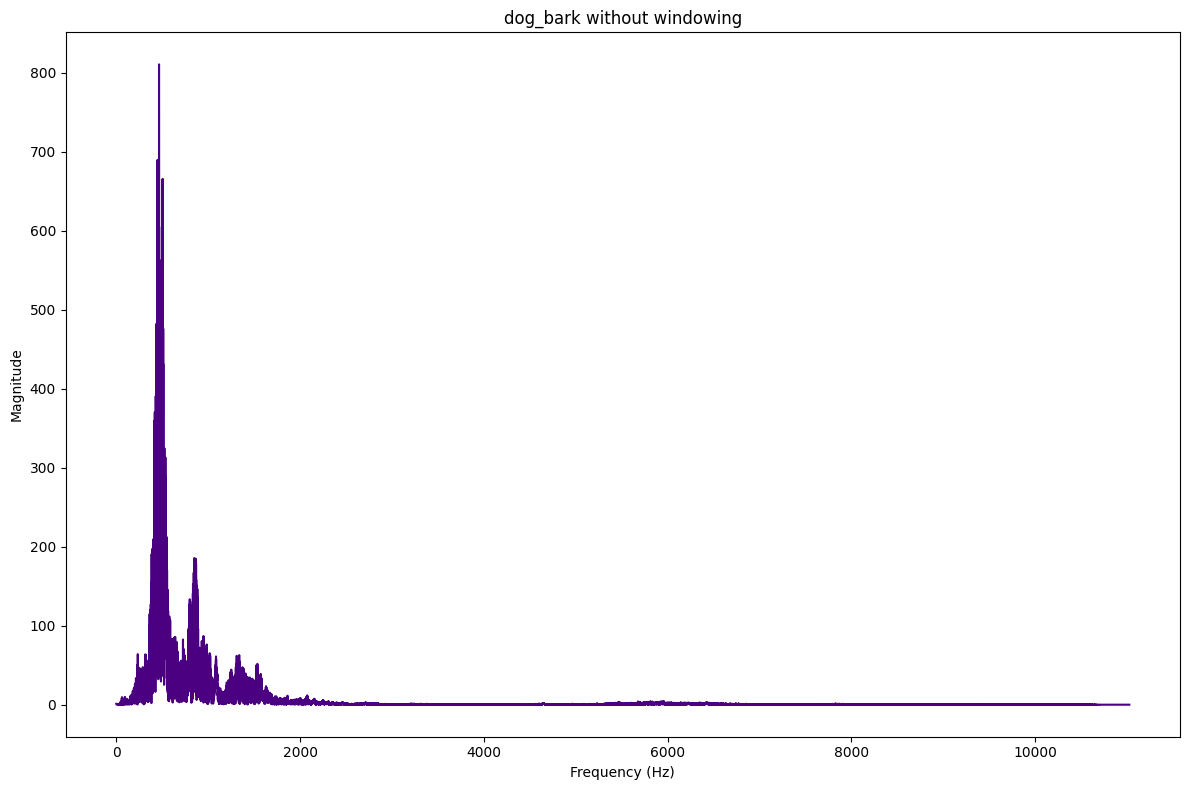

In [20]:
n_fft = len(processed_classes["dog_bark"]["audio_data"])  # FFT length is the entire signal length
fft_result = np.fft.fft(processed_classes["dog_bark"]["audio_data"])


#Compute magnitude and frequency bins
magnitude = np.abs(fft_result)
frequencies = np.fft.fftfreq(n_fft, d=1/22050)  #assuming a sample rate of 22050 Hz

plt.figure(figsize=(12, 8))
plt.plot(frequencies[:n_fft//2], magnitude[:n_fft//2], color="indigo")  
plt.title(f"{labels[0]} without windowing")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout()

plt.savefig(f'Dog_bark_no_windowing_spectrogram.png')
plt.show()

### Spectrogram of rectangular windowing applied to "Dog bark" audio

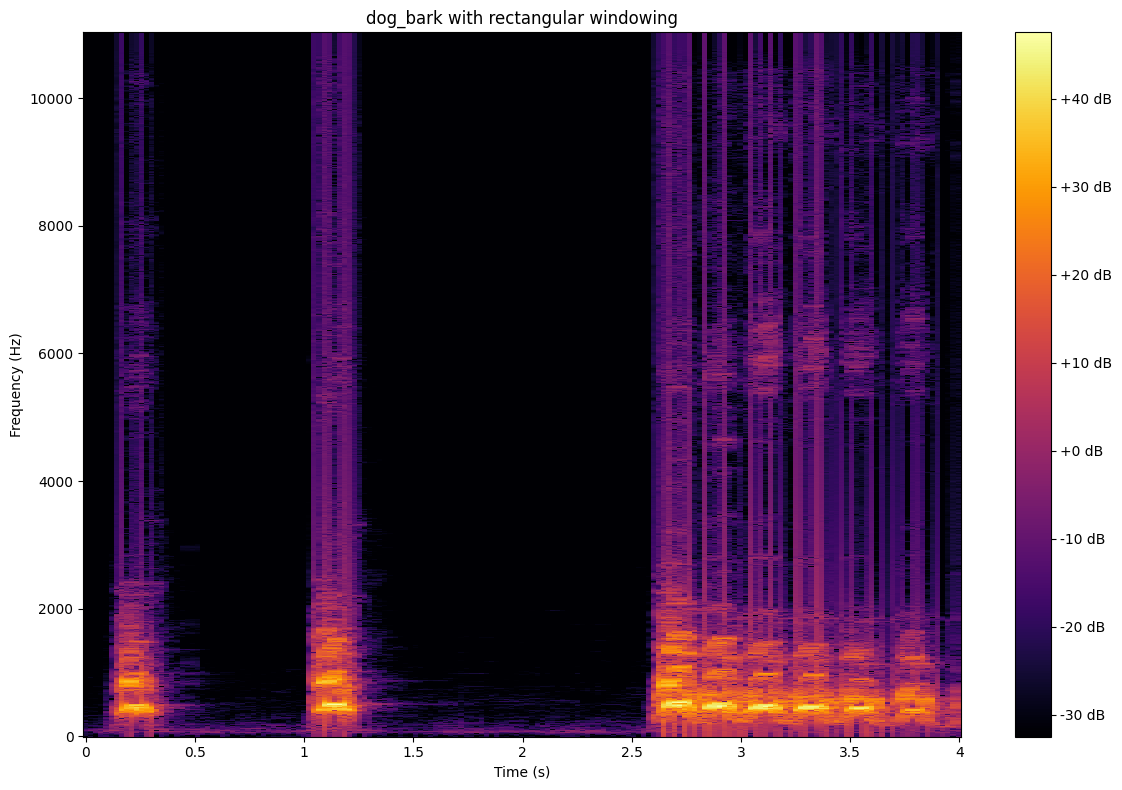

In [21]:

plt.figure(figsize=(12, 8))
librosa.display.specshow(processed_classes["dog_bark"]["spectrograms"]["Rectangular"], cmap="inferno",x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title(f"{labels[0]} with rectangular windowing")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.savefig(f'Dog_bark_with_rect_windowing_spectrogram.png')
plt.show()

### Spectrogram of Hann windowing applied to "Dog bark" audio

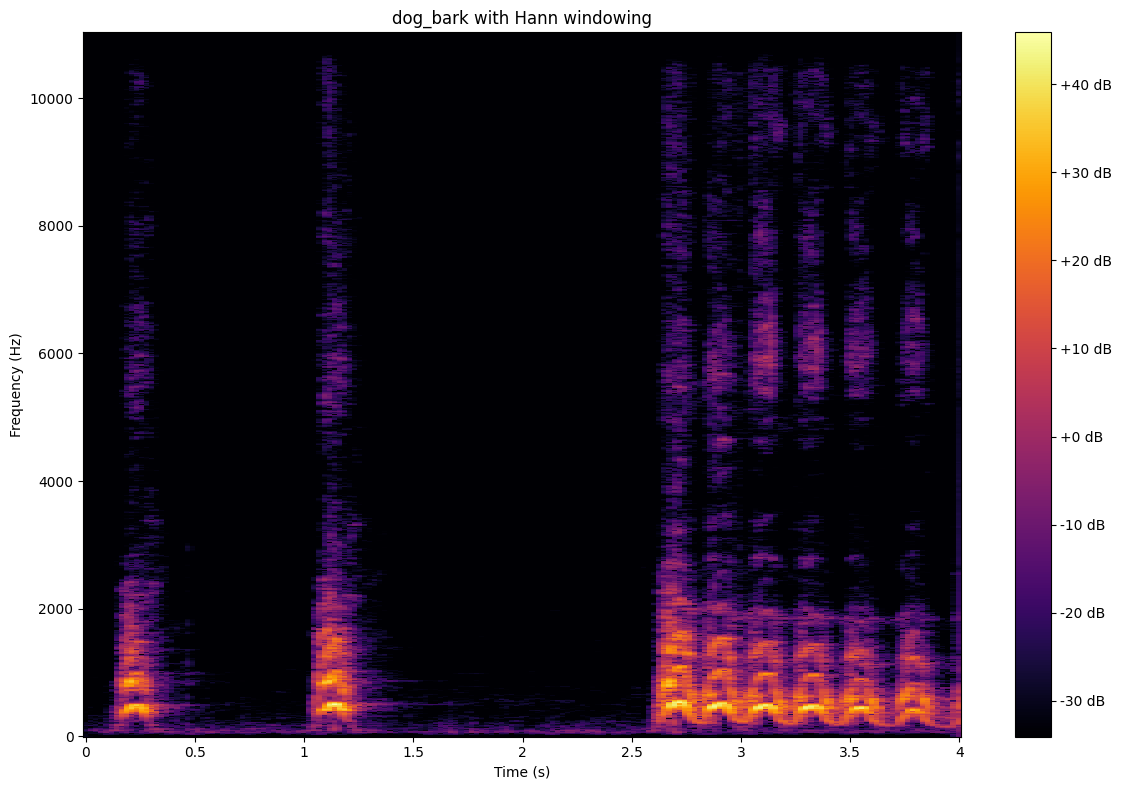

In [22]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(processed_classes["dog_bark"]["spectrograms"]["Hann"], cmap="inferno",x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title(f"{labels[0]} with Hann windowing")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.savefig(f'Dog_bark_with_Hann_windowing_spectrogram.png')
plt.show()

### Spectrogram of Hamming windowing applied to "Dog bark" audio

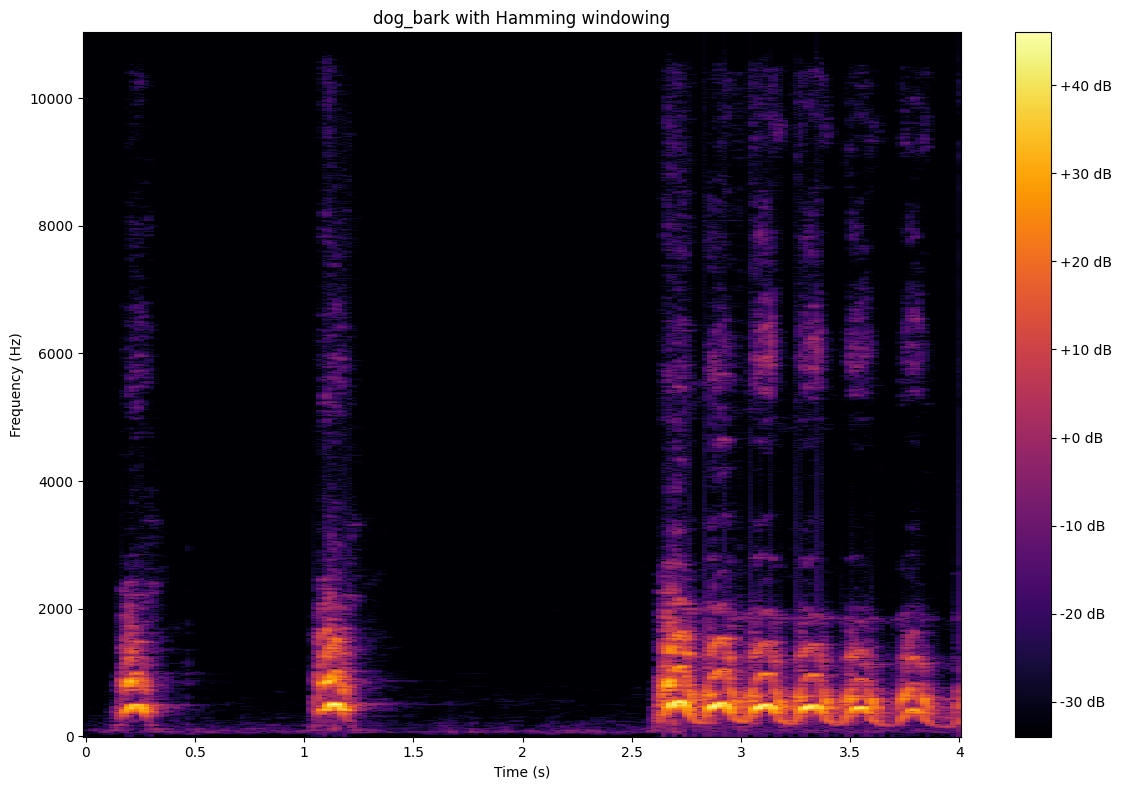

In [23]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(processed_classes["dog_bark"]["spectrograms"]["Hamming"], cmap="inferno",x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title(f"{labels[0]} with Hamming windowing")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.savefig(f'Dog_bark_with_Hamming_windowing_spectrogram.png')
plt.show()

### Global frequency components of "Gun shot" audio without windowing

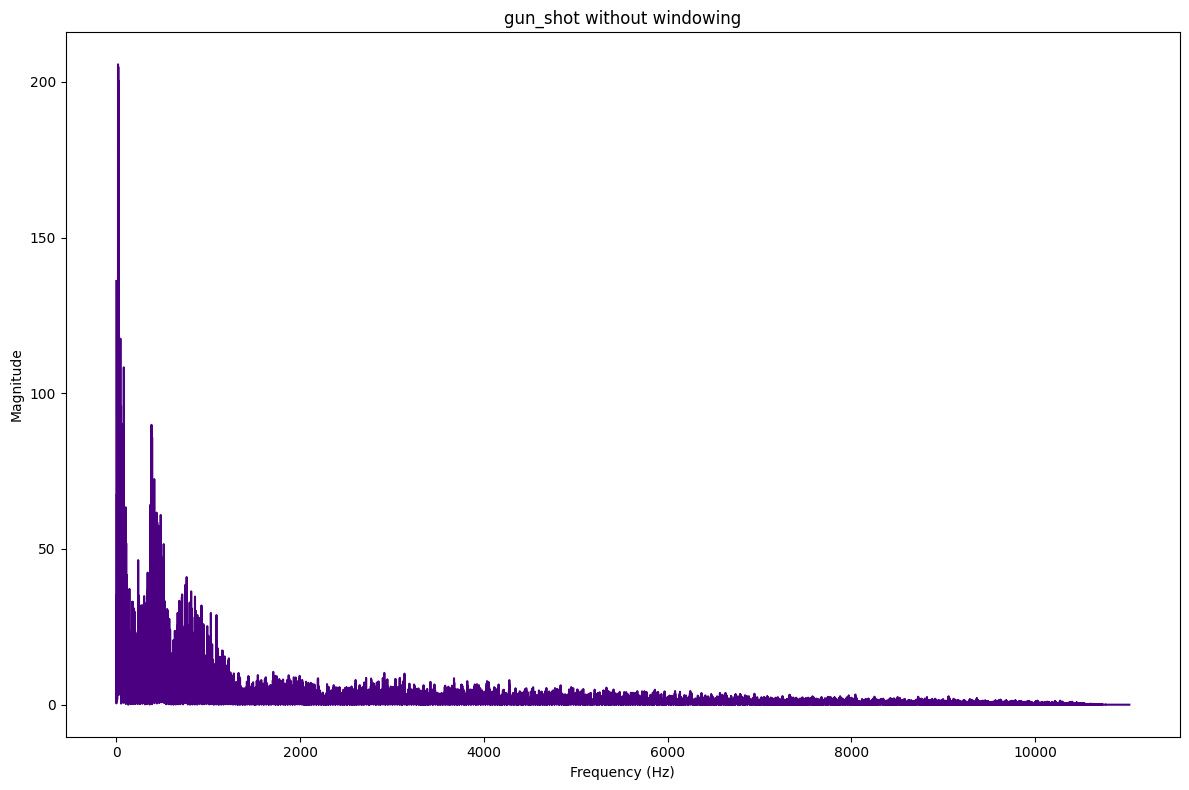

In [24]:
n_fft = len(processed_classes["gun_shot"]["audio_data"]) 
fft_result = np.fft.fft(processed_classes["gun_shot"]["audio_data"])
magnitude = np.abs(fft_result)
frequencies = np.fft.fftfreq(n_fft, d=1/22050) 

plt.figure(figsize=(12, 8))
plt.plot(frequencies[:n_fft//2], magnitude[:n_fft//2], color="indigo")  
plt.title(f"{labels[1]} without windowing")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout()

plt.savefig(f'Gun_shot_no_windowing_spectrogram.png')
plt.show()

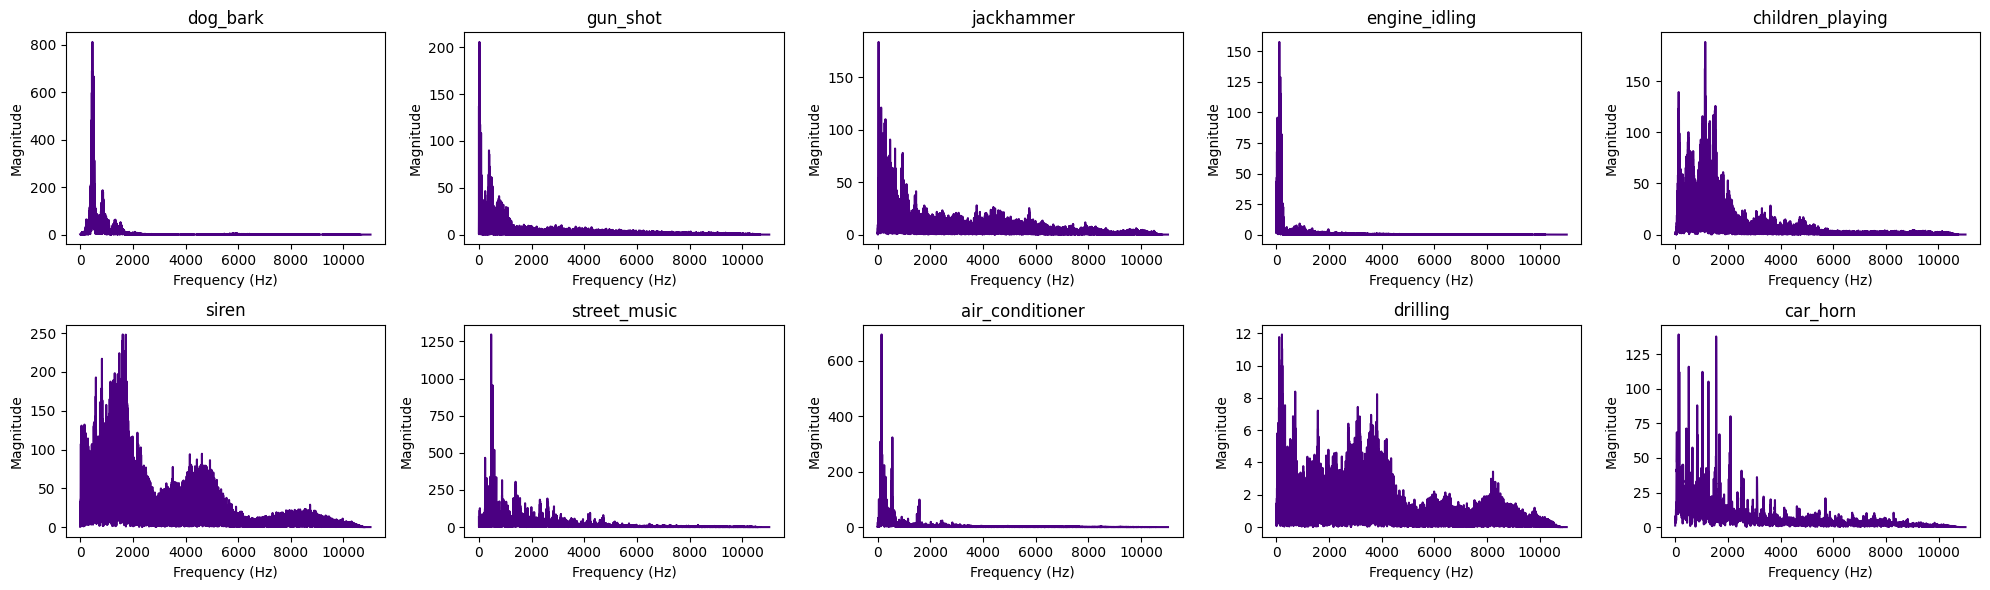

In [25]:
plt.figure(figsize=(20, 6))

classes = list(processed_classes.keys())
for i in range(10):
   
    audio_data = processed_classes[classes[i]]['audio_data']
    

    n_fft = len(audio_data) 
    fft_result = np.fft.fft(audio_data)
    magnitude = np.abs(fft_result)
    frequencies = np.fft.fftfreq(n_fft, d=1/22050)  
    plt.subplot(2, 5, i+1)
    plt.plot(frequencies[:n_fft//2], magnitude[:n_fft//2], color="indigo") 
    plt.title(classes[i])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")

plt.tight_layout()
plt.savefig('urban_sound_no_windowing_fft.png')
plt.show()


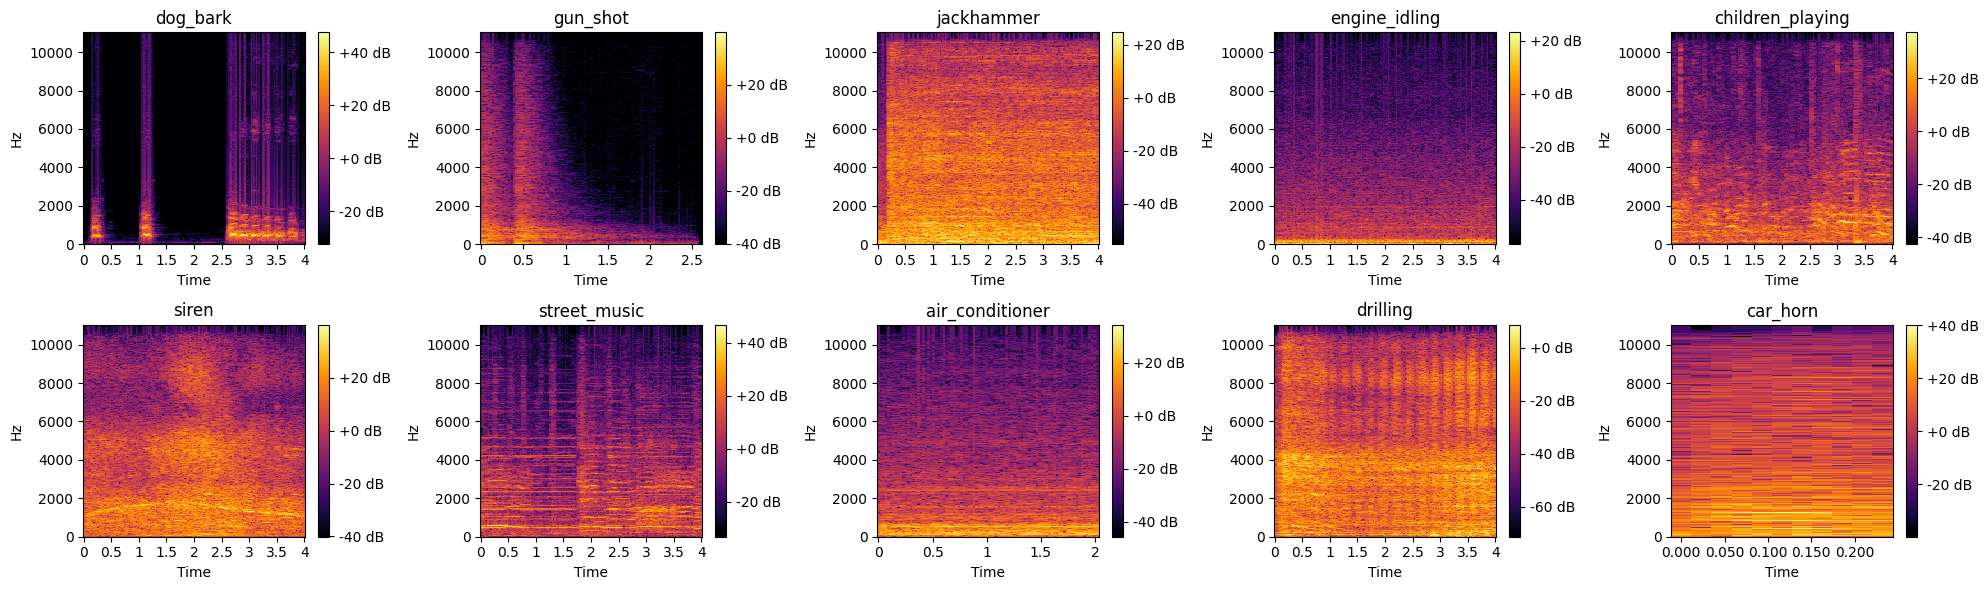

In [26]:
plt.figure(figsize=(20, 6))

classes = list(processed_classes.keys())

for i in range(10):
    plt.subplot(2, 5, i+1)
    spectrogram = processed_classes[classes[i]]['spectrograms']['Rectangular']
    librosa.display.specshow(spectrogram, cmap='inferno', x_axis='time', y_axis='hz')
    plt.title(classes[i])
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.savefig('urban_sound_spectrograms_Rectangular_with_no_padding.png')
plt.show()

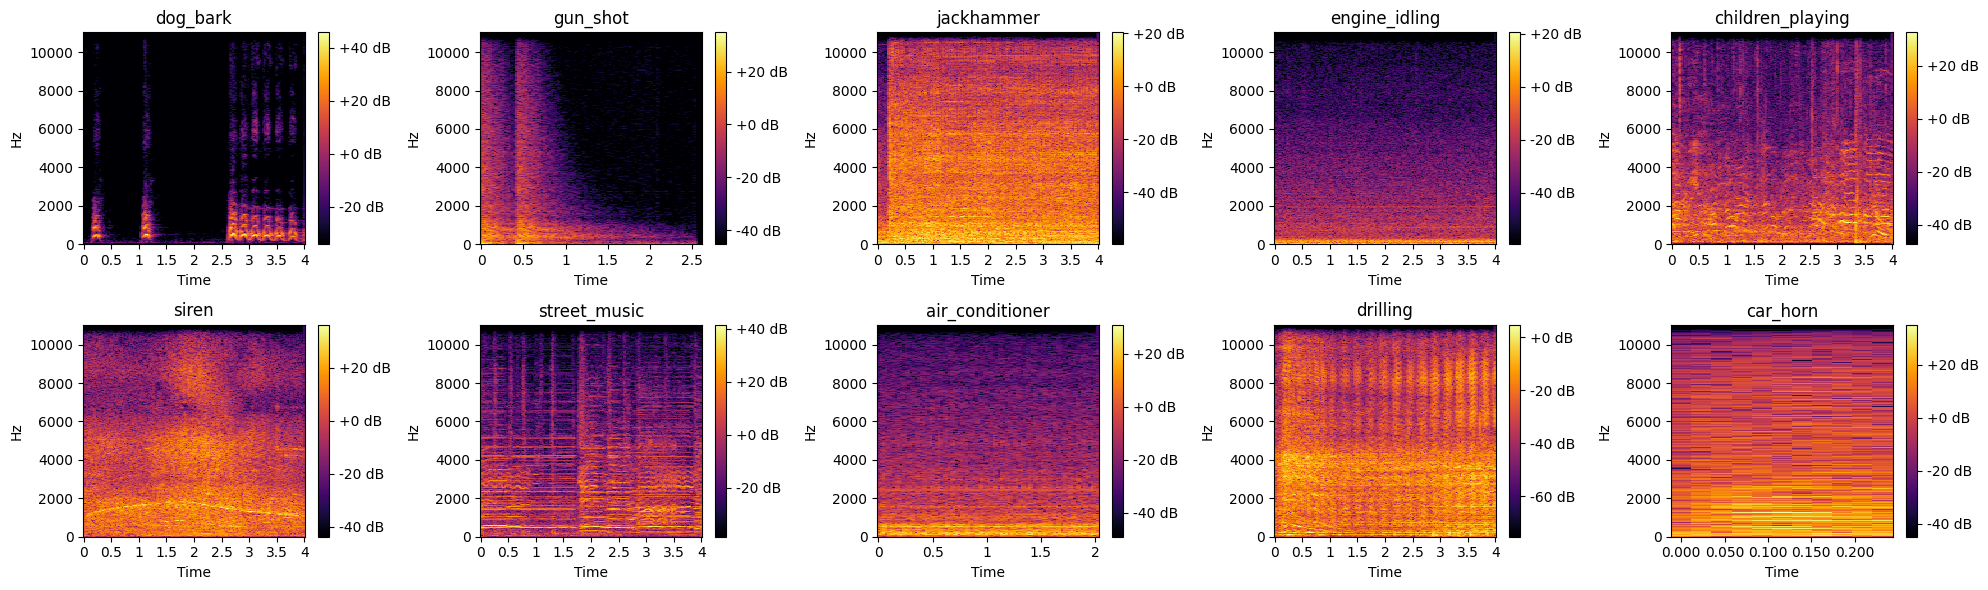

In [27]:
plt.figure(figsize=(20, 6))

classes = list(processed_classes.keys())

for i in range(10):
    plt.subplot(2, 5, i+1)
    spectrogram = processed_classes[classes[i]]['spectrograms']['Hann']
    librosa.display.specshow(spectrogram, cmap='inferno', x_axis='time', y_axis='hz')
    plt.title(classes[i])
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.savefig('urban_sound_spectrograms_Hann.png')
plt.show()

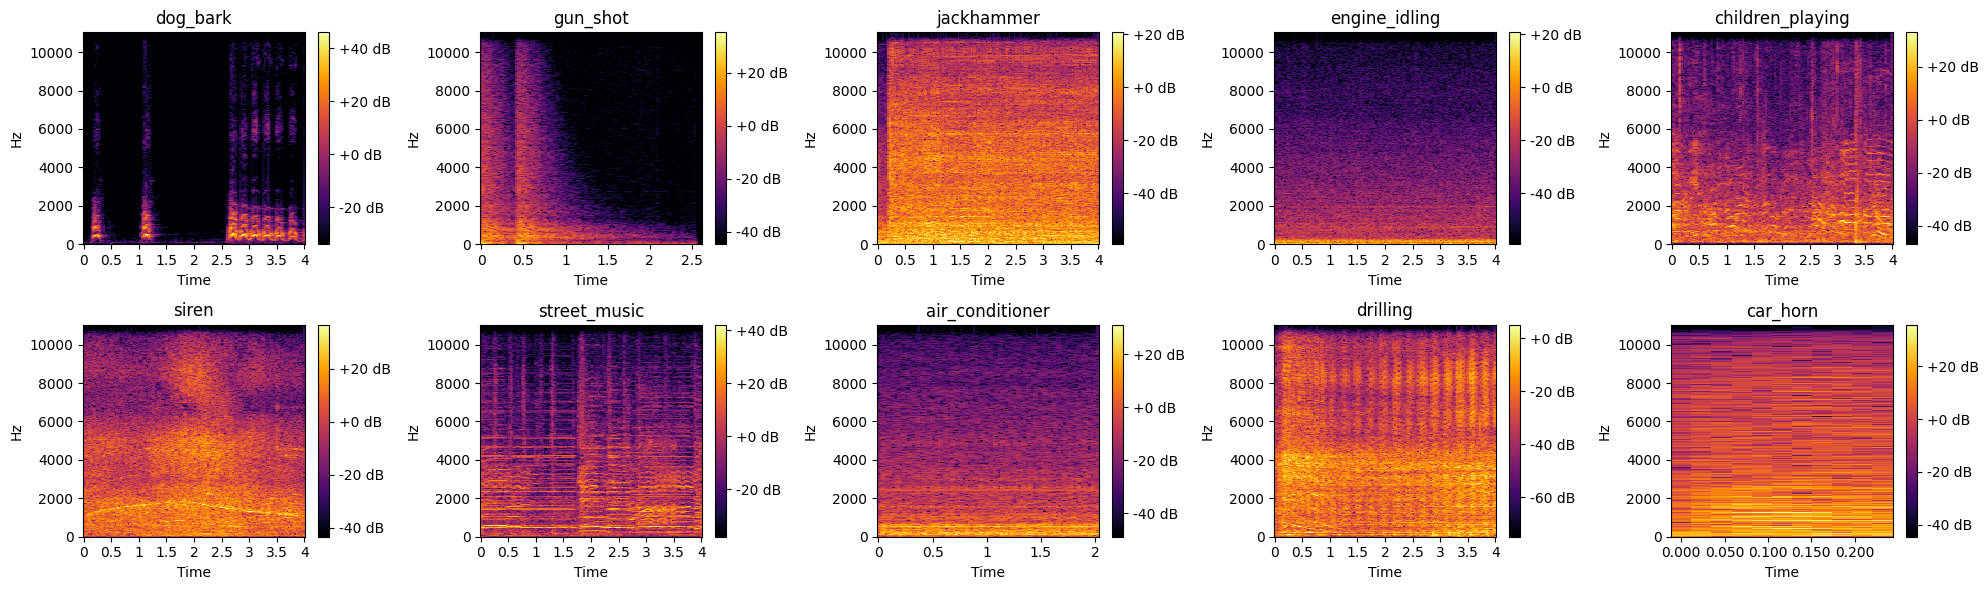

In [28]:
plt.figure(figsize=(20, 6))

classes = list(processed_classes.keys())

for i in range(10):
    plt.subplot(2, 5, i+1)
    spectrogram = processed_classes[classes[i]]['spectrograms']['Hamming']
    librosa.display.specshow(spectrogram, cmap='inferno', x_axis='time', y_axis='hz')
    plt.title(classes[i])
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.savefig('urban_sound_spectrograms_Hamming.png')
plt.show()

## Training machine learning classifiers with no padding

In [15]:
def load_urbansound_dataset(dataset_path):
    metadata = pd.read_csv(os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv'))
    metadata=metadata[metadata['fold']== 1]
    return metadata

In [16]:
def apply_windows(audio_data):
    """Apply different window functions to audio data and compute spectrograms."""

    def hann_window(M):
        n = np.arange(M)
        return 0.5 * (1 - np.cos(2 * np.pi * n / (M - 1)))
        
    windows = {
        'Rectangular': np.ones, 
        'Hann': hann_window,
        'Hamming': signal.windows.hamming
    }
    
    # Parameters for STFT
    n_fft = 1024
    hop_length = n_fft // 2
    
    windowed_results = {}
    for window_name, window_func in windows.items():
        window = window_func(n_fft)
        
        # Compute STFT
        stft = librosa.stft(
            audio_data,
            n_fft=n_fft,
            hop_length=hop_length,
            window=window
        )
        spectrogram = librosa.amplitude_to_db(np.abs(stft))
        windowed_results[window_name] = spectrogram
        
        
    
    return windowed_results


In [17]:
def extract_features(spectrogram, sr=None):
    """
    Extract various features from a spectrogram, including:
    - Mean, standard deviation, skewness, kurtosis, min, max, median, energy
    - Mel-frequency cepstral coefficients (MFCCs)
    - Chroma features
    - Spectral contrast
    - Tonnetz features
    """
    # Spectrogram-based features
    mean_features = np.mean(spectrogram, axis=1)
    std_features = np.std(spectrogram, axis=1)
    skewness_features = np.mean(((spectrogram - mean_features[:, None]) ** 3), axis=1) / (std_features ** 3 + 1e-8)
    kurtosis_features = np.mean(((spectrogram - mean_features[:, None]) ** 4), axis=1) / (std_features ** 4 + 1e-8) - 3
    min_features = np.min(spectrogram, axis=1)
    max_features = np.max(spectrogram, axis=1)
    median_features = np.median(spectrogram, axis=1)
    energy_features = np.sum(spectrogram ** 2, axis=1)

    mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram)
    
    # MFCCs (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std = np.std(mfccs, axis=1)

    # Chroma Features
    chroma = librosa.feature.chroma_stft(S=mel_spectrogram)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)

    # Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(S=mel_spectrogram)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
    spectral_contrast_std = np.std(spectral_contrast, axis=1)

    return np.concatenate([
        mean_features,
        std_features,
        skewness_features,
        kurtosis_features,
        min_features,
        max_features,
        median_features,
        energy_features,
        mfcc_mean,
        mfcc_std,
        chroma_mean,
        chroma_std,
        spectral_contrast_mean,
        spectral_contrast_std,
    ])


## SVM with padding

In [22]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


SAMPLE_RATE = 22050
DURATION = 3
TARGET_LENGTH = SAMPLE_RATE * DURATION 
dataset_path = 'UrbanSound8K/UrbanSound8K/'
metadata = pd.read_csv(os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv'))


train_metadata = metadata[metadata['fold'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9])]
test_metadata = metadata[metadata['fold'] == 10]

window_features_train = {'Rectangular': [], 'Hann': [], 'Hamming': []}
window_features_test = {'Rectangular': [], 'Hann': [], 'Hamming': []}
train_labels = []
test_labels = []


for _, row in train_metadata.iterrows():
    audio_path = os.path.join(dataset_path, 'audio', f'fold{row["fold"]}', row['slice_file_name'])
    audio_data, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    if len(audio_data) < TARGET_LENGTH:
        audio_data = np.pad(audio_data, (0, TARGET_LENGTH - len(audio_data)), mode='constant')
    else:
        audio_data = audio_data[:TARGET_LENGTH]
    windowed_results = apply_windows(audio_data)
    
    for window_name, spectrogram in windowed_results.items():
        features = extract_features(spectrogram, sr=SAMPLE_RATE)
        window_features_train[window_name].append(features)
    
    train_labels.append(row['class'])


for _, row in test_metadata.iterrows():
    audio_path = os.path.join(dataset_path, 'audio', f'fold{row["fold"]}', row['slice_file_name'])
    audio_data, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    if len(audio_data) < TARGET_LENGTH:
        audio_data = np.pad(audio_data, (0, TARGET_LENGTH - len(audio_data)), mode='constant')
    else:
        audio_data = audio_data[:TARGET_LENGTH]
    windowed_results = apply_windows(audio_data)
    
    for window_name, spectrogram in windowed_results.items():
        features = extract_features(spectrogram, sr=SAMPLE_RATE)
        window_features_test[window_name].append(features)
    
    test_labels.append(row['class'])


results = {}
for window_name in window_features_train.keys():
    X_train = np.array(window_features_train[window_name])
    X_test = np.array(window_features_test[window_name])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svm = SVC(kernel='rbf')
    svm.fit(X_train_scaled, train_labels)
    
    y_pred = svm.predict(X_test_scaled)
    
    cm = confusion_matrix(test_labels, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(set(train_labels)), 
                yticklabels=sorted(set(train_labels)))
    plt.title(f'Confusion Matrix - {window_name} Window with padding')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'{window_name}_confusion_matrix_with_padding.png')
    plt.close()
    
    results[window_name] = {
        'classification_report': classification_report(test_labels, y_pred),
        'confusion_matrix': cm
    }
    
    print(f"\n{window_name} Window Results:")
    print(results[window_name]['classification_report'])


Rectangular Window Results:
                  precision    recall  f1-score   support

 air_conditioner       0.69      0.81      0.75       100
        car_horn       0.95      0.61      0.74        33
children_playing       0.53      0.74      0.62       100
        dog_bark       0.77      0.58      0.66       100
        drilling       0.39      0.51      0.44       100
   engine_idling       0.71      0.71      0.71        93
        gun_shot       0.88      0.72      0.79        32
      jackhammer       0.48      0.33      0.40        96
           siren       0.55      0.39      0.45        83
    street_music       0.69      0.75      0.72       100

        accuracy                           0.61       837
       macro avg       0.67      0.61      0.63       837
    weighted avg       0.63      0.61      0.61       837


Hann Window Results:
                  precision    recall  f1-score   support

 air_conditioner       0.55      0.83      0.66       100
        car_horn 

In [16]:
 results["Hann"]["confusion_matrix"]

array([[17,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 1,  5,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 15,  0,  1,  0,  0,  0,  0,  1],
       [ 0,  0,  1, 22,  1,  0,  1,  0,  1,  1],
       [ 0,  0,  1,  0, 19,  0,  0,  0,  0,  2],
       [ 1,  0,  0,  0,  0, 21,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0],
       [ 0,  0,  1,  1,  0,  4,  0,  1, 11,  0],
       [ 0,  0,  3,  1,  0,  0,  0,  0,  0, 15]], dtype=int64)

## SVM with no padding

In [18]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


SAMPLE_RATE = 22050

dataset_path = 'UrbanSound8K/UrbanSound8K/'
metadata = pd.read_csv(os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv'))


train_metadata = metadata[metadata['fold'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9])]
test_metadata = metadata[metadata['fold'] == 10]

window_features_train = {'Rectangular': [], 'Hann': [], 'Hamming': []}
window_features_test = {'Rectangular': [], 'Hann': [], 'Hamming': []}
train_labels = []
test_labels = []


for _, row in train_metadata.iterrows():
    audio_path = os.path.join(dataset_path, 'audio', f'fold{row["fold"]}', row['slice_file_name'])
    audio_data, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    windowed_results = apply_windows(audio_data)
    
    for window_name, spectrogram in windowed_results.items():
        features = extract_features(spectrogram, sr=SAMPLE_RATE)
        window_features_train[window_name].append(features)
    
    train_labels.append(row['class'])


for _, row in test_metadata.iterrows():
    audio_path = os.path.join(dataset_path, 'audio', f'fold{row["fold"]}', row['slice_file_name'])
    audio_data, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    windowed_results = apply_windows(audio_data)
    
    for window_name, spectrogram in windowed_results.items():
        features = extract_features(spectrogram, sr=SAMPLE_RATE)
        window_features_test[window_name].append(features)
    
    test_labels.append(row['class'])


results = {}
for window_name in window_features_train.keys():
    X_train = np.array(window_features_train[window_name])
    X_test = np.array(window_features_test[window_name])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svm = SVC(kernel='rbf')
    svm.fit(X_train_scaled, train_labels)
    y_pred = svm.predict(X_test_scaled)
    
    cm = confusion_matrix(test_labels, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(set(train_labels)), 
                yticklabels=sorted(set(train_labels)))
    plt.title(f'Confusion Matrix - {window_name} Window no padding_svm')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'{window_name}_confusion_matrix_no_padding_svm.png')
    plt.close()
    
    results[window_name] = {
        'classification_report': classification_report(test_labels, y_pred),
        'confusion_matrix': cm
    }
    
    print(f"\n{window_name} Window Results:")
    print(results[window_name]['classification_report'])



Rectangular Window Results:
                  precision    recall  f1-score   support

 air_conditioner       0.77      0.77      0.77       100
        car_horn       0.83      0.61      0.70        33
children_playing       0.56      0.76      0.64       100
        dog_bark       0.82      0.65      0.73       100
        drilling       0.58      0.52      0.55       100
   engine_idling       0.69      0.85      0.76        93
        gun_shot       0.93      0.88      0.90        32
      jackhammer       0.66      0.68      0.67        96
           siren       0.56      0.37      0.45        83
    street_music       0.71      0.78      0.74       100

        accuracy                           0.68       837
       macro avg       0.71      0.69      0.69       837
    weighted avg       0.69      0.68      0.68       837


Hann Window Results:
                  precision    recall  f1-score   support

 air_conditioner       0.54      0.82      0.65       100
        car_horn 

## Random Forest with no padding

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
SAMPLE_RATE = 22050
dataset_path = 'UrbanSound8K/UrbanSound8K/'
metadata = pd.read_csv(os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv'))


train_metadata = metadata[metadata['fold'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9])]
test_metadata = metadata[metadata['fold'] == 10]


window_features_train = {'Rectangular': [], 'Hann': [], 'Hamming': []}
window_features_test = {'Rectangular': [], 'Hann': [], 'Hamming': []}
train_labels = []
test_labels = []


for _, row in train_metadata.iterrows():
    audio_path = os.path.join(dataset_path, 'audio', f'fold{row["fold"]}', row['slice_file_name'])
    audio_data, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    windowed_results = apply_windows(audio_data)
    
    for window_name, spectrogram in windowed_results.items():
        features = extract_features(spectrogram, sr=SAMPLE_RATE)
        window_features_train[window_name].append(features)
    
    train_labels.append(row['class'])

for _, row in test_metadata.iterrows():
    audio_path = os.path.join(dataset_path, 'audio', f'fold{row["fold"]}', row['slice_file_name'])
    audio_data, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    windowed_results = apply_windows(audio_data)
    
    for window_name, spectrogram in windowed_results.items():
        features = extract_features(spectrogram, sr=SAMPLE_RATE)
        window_features_test[window_name].append(features)
    
    test_labels.append(row['class'])

results = {}
for window_name in window_features_train.keys():
    X_train = np.array(window_features_train[window_name])
    X_test = np.array(window_features_test[window_name])
    
 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    rf = RandomForestClassifier(
        random_state=42)
    rf.fit(X_train_scaled, train_labels)
    
   
    y_pred = rf.predict(X_test_scaled)
    
   
    cm = confusion_matrix(test_labels, y_pred)
    
 
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(set(train_labels)), 
                yticklabels=sorted(set(train_labels)))
    plt.title(f'Confusion Matrix - {window_name} Window (Random Forest)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'{window_name}_confusion_matrix_random_forest.png')
    plt.close()
    
    
    feature_importance = pd.DataFrame({
        'feature': range(X_train.shape[1]),
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='feature', y='importance')
    plt.title(f'Top 10 Feature Importance - {window_name} Window')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig(f'{window_name}_feature_importance_random_forest.png')
    plt.close()
    
    results[window_name] = {
        'classification_report': classification_report(test_labels, y_pred),
        'confusion_matrix': cm,
        'feature_importance': feature_importance
    }
    
    print(f"\n{window_name} Window Results:")
    print(results[window_name]['classification_report'])


Rectangular Window Results:
                  precision    recall  f1-score   support

 air_conditioner       0.57      0.74      0.64       100
        car_horn       0.45      0.45      0.45        33
children_playing       0.53      0.80      0.63       100
        dog_bark       0.72      0.56      0.63       100
        drilling       0.34      0.51      0.41       100
   engine_idling       0.56      0.41      0.47        93
        gun_shot       0.92      0.72      0.81        32
      jackhammer       0.54      0.23      0.32        96
           siren       0.51      0.25      0.34        83
    street_music       0.62      0.75      0.68       100

        accuracy                           0.54       837
       macro avg       0.58      0.54      0.54       837
    weighted avg       0.56      0.54      0.53       837


Hann Window Results:
                  precision    recall  f1-score   support

 air_conditioner       0.50      0.69      0.58       100
        car_horn 